<a href="https://colab.research.google.com/github/kridtapon/Normalized-Multi-Indicator-Trend-System/blob/main/Normalized_Multi_Indicator_Trend_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.3 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# === Download Data ===
symbol = 'META'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

def normalize_series(series, window=100):
    min_val = series.rolling(window).min()
    max_val = series.rolling(window).max()
    normalized = (series - min_val) / (max_val - min_val)
    return normalized.clip(0, 1)

def calculate_normalized_atr(df, window=14, norm_window=100):
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift(1))
    low_close = np.abs(df['Low'] - df['Close'].shift(1))
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window=window).mean()
    return normalize_series(atr, window=norm_window)

def calculate_normalized_mass_index(df, period=14, norm_window=100):
    high_low = df['High'] - df['Low']
    ema_high_low = high_low.ewm(span=period).mean()
    mi = (high_low / ema_high_low).rolling(window=period).sum()
    return normalize_series(mi, window=norm_window)

def calculate_normalized_hma(df, period=20, norm_window=100):
    close = df['Close']
    wma1 = close.rolling(period // 2).mean()
    wma2 = close.rolling(period).mean()
    hma_raw = 2 * wma1 - wma2
    hma = hma_raw.rolling(int(np.sqrt(period))).mean()
    return normalize_series(hma, window=norm_window)

def calculate_normalized_cci(df, window=20, norm_window=100):
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    ma = typical_price.rolling(window=window).mean()
    md = (typical_price - ma).abs().rolling(window=window).mean()
    cci = (typical_price - ma) / (0.015 * md)
    return normalize_series(cci, window=norm_window)

def calculate_ema_trend_normalized(df, fast_period=20, slow_period=50):
    ema_fast = df['Close'].ewm(span=fast_period).mean()
    ema_slow = df['Close'].ewm(span=slow_period).mean()
    trend_signal = (ema_fast > ema_slow).astype(float)
    return trend_signal  # Already 0 (bearish) or 1 (bullish)

df['ATR_norm'] = calculate_normalized_atr(df)
df['MI_norm'] = calculate_normalized_mass_index(df)
df['HMA_norm'] = calculate_normalized_hma(df)
df['CCI_norm'] = calculate_normalized_cci(df)
df['EMA_Trend_norm'] = calculate_ema_trend_normalized(df)

# === Filter Test Period ===
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# === Create Composite Proxy ===
norm_columns = ['ATR_norm', 'MI_norm', 'HMA_norm', 'CCI_norm', 'EMA_Trend_norm']
df['Composite_Proxy'] = df[norm_columns].mean(axis=1)

# === Entry & Exit Logic ===
# Define thresholds
entry_threshold = 0.7  # bullish entry
exit_threshold = 0.3   # bearish exit

# Entry when composite crosses above entry_threshold
# Exit when composite crosses below exit_threshold
entry_signal = (df['Composite_Proxy'] > entry_threshold)
exit_signal = (df['Composite_Proxy'] < exit_threshold)

# === Shift signals to next day ===
shift_entries = entry_signal.shift(1).fillna(False).astype(bool).to_numpy()
shift_exits = exit_signal.shift(1).fillna(False).astype(bool).to_numpy()

# === Backtest with vectorbt ===
pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# === Results ===
print(pf.stats())
pf.plot().show()

[*********************100%***********************]  1 of 1 completed
<ipython-input-4-e9ffe201ab7a>:77: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  shift_entries = entry_signal.shift(1).fillna(False).astype(bool).to_numpy()
<ipython-input-4-e9ffe201ab7a>:78: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  shift_exits = exit_signal.shift(1).fillna(False).astype(bool).to_numpy()


Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           590754.554783
Total Return [%]                       490.754555
Benchmark Return [%]                   187.561061
Max Gross Exposure [%]                      100.0
Total Fees Paid                        652.825718
Max Drawdown [%]                        37.210775
Max Drawdown Duration           349 days 00:00:00
Total Trades                                    3
Total Closed Trades                             2
Total Open Trades                               1
Open Trade PnL                      441848.290677
Win Rate [%]                                100.0
Best Trade [%]                          27.583825
Worst Trade [%]                         16.754446
Avg Winning Trade [%]                   22.169135
Avg Losing Trade [%]                          NaN


In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# === Download Data ===
symbol = 'STX'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

def normalize_series(series, window=100):
    min_val = series.rolling(window).min()
    max_val = series.rolling(window).max()
    normalized = (series - min_val) / (max_val - min_val)
    return normalized.clip(0, 1)

def calculate_normalized_atr(df, window=14, norm_window=100):
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift(1))
    low_close = np.abs(df['Low'] - df['Close'].shift(1))
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window=window).mean()
    return normalize_series(atr, window=norm_window)

def calculate_normalized_mass_index(df, period=14, norm_window=100):
    high_low = df['High'] - df['Low']
    ema_high_low = high_low.ewm(span=period).mean()
    mi = (high_low / ema_high_low).rolling(window=period).sum()
    return normalize_series(mi, window=norm_window)

def calculate_normalized_hma(df, period=20, norm_window=100):
    close = df['Close']
    wma1 = close.rolling(period // 2).mean()
    wma2 = close.rolling(period).mean()
    hma_raw = 2 * wma1 - wma2
    hma = hma_raw.rolling(int(np.sqrt(period))).mean()
    return normalize_series(hma, window=norm_window)

def calculate_normalized_cci(df, window=20, norm_window=100):
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    ma = typical_price.rolling(window=window).mean()
    md = (typical_price - ma).abs().rolling(window=window).mean()
    cci = (typical_price - ma) / (0.015 * md)
    return normalize_series(cci, window=norm_window)

def calculate_ema_trend_normalized(df, fast_period=20, slow_period=50):
    ema_fast = df['Close'].ewm(span=fast_period).mean()
    ema_slow = df['Close'].ewm(span=slow_period).mean()
    trend_signal = (ema_fast > ema_slow).astype(float)
    return trend_signal  # Already 0 (bearish) or 1 (bullish)

# Calculate normalized indicators
df['ATR_norm'] = calculate_normalized_atr(df)
df['MI_norm'] = calculate_normalized_mass_index(df)
df['HMA_norm'] = calculate_normalized_hma(df)
df['CCI_norm'] = calculate_normalized_cci(df)
df['EMA_Trend_norm'] = calculate_ema_trend_normalized(df)

# === Filter Test Period ===
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# === Create Composite Proxy with weights ===
norm_columns = ['ATR_norm', 'MI_norm', 'HMA_norm', 'CCI_norm', 'EMA_Trend_norm']

weights = {
    'ATR_norm': 0.2,
    'MI_norm': 0.2,
    'HMA_norm': 0.2,
    'CCI_norm': 0.2,
    'EMA_Trend_norm': 0.2
}

weights_array = np.array([weights[col] for col in norm_columns])

df['Composite_Proxy'] = df[norm_columns].multiply(weights_array, axis=1).sum(axis=1) / weights_array.sum()

# === Entry & Exit Logic ===
entry_threshold = 0.7  # bullish entry
exit_threshold = 0.3   # bearish exit

entry_signal = (df['Composite_Proxy'] > entry_threshold)
exit_signal = (df['Composite_Proxy'] < exit_threshold)

# === Shift signals to next day ===
shift_entries = entry_signal.shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = exit_signal.shift(1).astype(bool).fillna(False).to_numpy()

# === Backtest with vectorbt ===
pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# === Results ===
print(pf.stats())
pf.plot().show()


[*********************100%***********************]  1 of 1 completed


Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           230782.817796
Total Return [%]                       130.782818
Benchmark Return [%]                    76.230652
Max Gross Exposure [%]                      100.0
Total Fees Paid                       1863.307013
Max Drawdown [%]                        27.236998
Max Drawdown Duration           645 days 00:00:00
Total Trades                                    6
Total Closed Trades                             6
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 50.0
Best Trade [%]                          85.625539
Worst Trade [%]                        -12.544071
Avg Winning Trade [%]                   44.007753
Avg Losing Trade [%]                    -6.070015


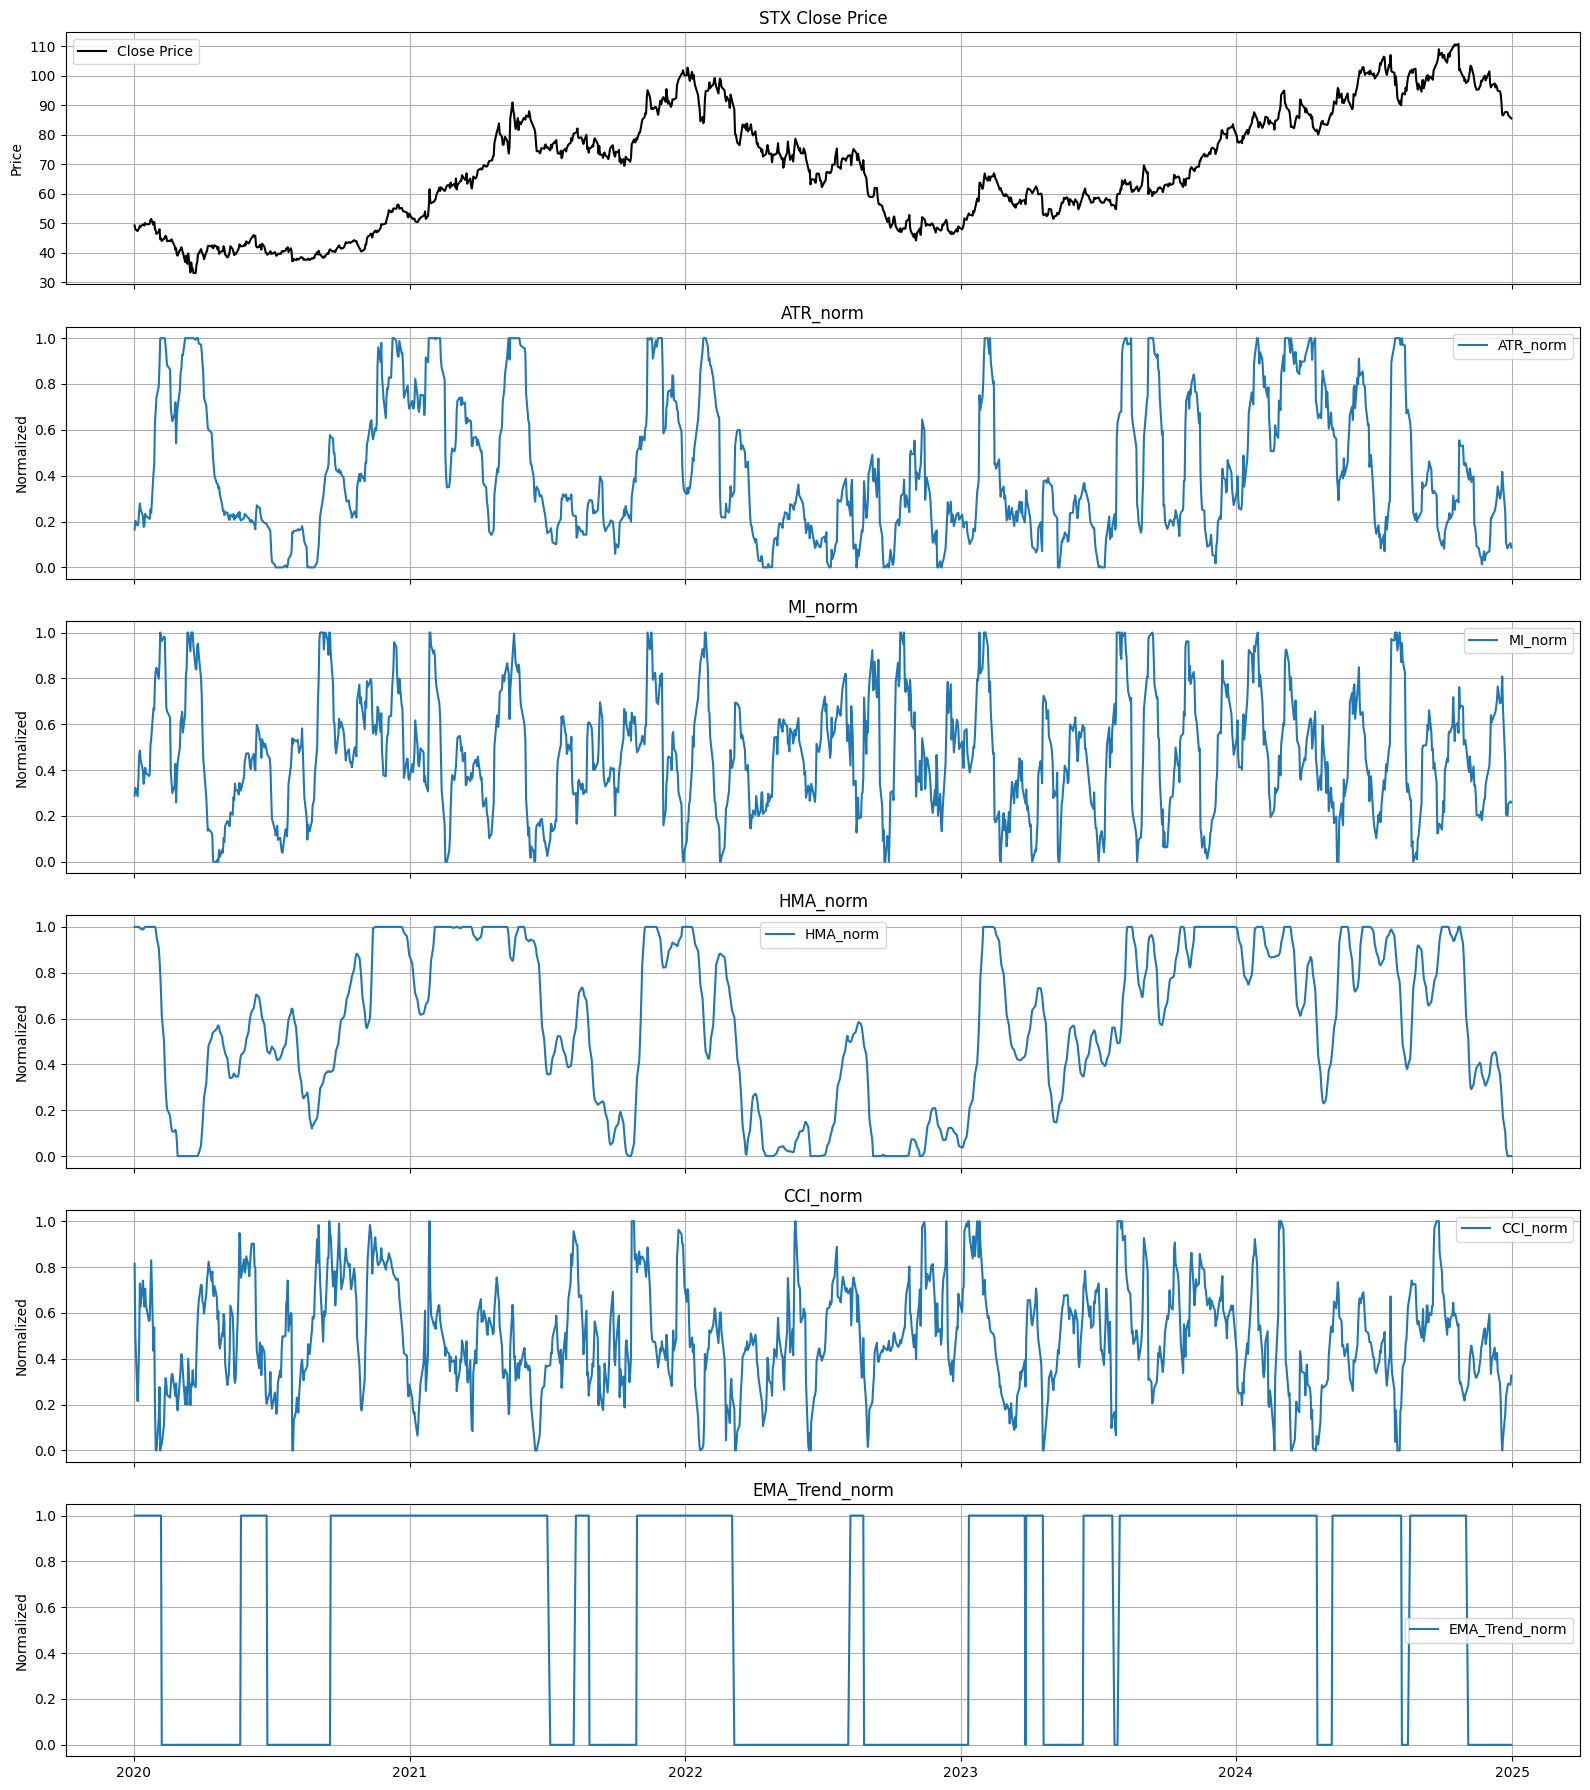

In [7]:
import matplotlib.pyplot as plt

# List of indicators to plot
indicators = ['ATR_norm', 'MI_norm', 'HMA_norm', 'CCI_norm', 'EMA_Trend_norm']
n_panels = len(indicators) + 1  # +1 for the Close Price

# Set up the plot with subplots
fig, axes = plt.subplots(n_panels, 1, figsize=(16, 3 * n_panels), sharex=True)

# Plot Close Price
axes[0].plot(df['Close'], label='Close Price', color='black')
axes[0].set_title('STX Close Price')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True)

# Plot each indicator in its own panel
for i, ind in enumerate(indicators):
    axes[i + 1].plot(df[ind], label=ind, linewidth=1.5)
    axes[i + 1].set_title(ind)
    axes[i + 1].set_ylabel('Normalized')
    axes[i + 1].legend()
    axes[i + 1].grid(True)

plt.tight_layout()
plt.show()